In [1]:
# HuggingFace transformers 설치
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 74.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, ElectraForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [3]:
# GPU 사용
device = torch.device("cuda")

# Dataset 만들어서 불러오기 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/데브/한국어_단발성_대화_정리.csv')
# data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,불안
1,그냥 내 느낌일뿐겠지?,불안
2,아직너무초기라서 그런거죠?,불안
3,유치원버스 사고 낫다던데,중립
4,근데 원래이런거맞나요,불안
...,...,...
19478,형~! 쵝오~!~!,행복
19479,유느님 내일 이면 해피투게더가하네요~^^,행복
19480,승관아~ 너에게 편지를 안 쓸 수가 없네.,행복
19481,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,행복


In [ ]:
# data.loc[(data["Emotion"] == "행복"), "Emotion"] = 0
# data.loc[(data["Emotion"] == "중립"), "Emotion"] = 1
# data.loc[(data["Emotion"] == "분노"), "Emotion"] = 2
# data.loc[(data["Emotion"] == "슬픔"), "Emotion"] = 3
# data.loc[(data["Emotion"] == "불안"), "Emotion"] = 4

# data_list = []
# for q, label in zip(data['Sentence'], data['Emotion'])  :
#     data = []
#     data.append(q)
#     data.append(str(label))

#     data_list.append(data)

In [ ]:
# #train & test 데이터로 나누기
# from sklearn.model_selection import train_test_split

# dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [ ]:
# print(len(dataset_train))
# print(len(dataset_test))

15586
3897


In [22]:
train_path = '/content/drive/MyDrive/데브/train_data_1.xlsx'
test_path = '/content/drive/MyDrive/데브/test_data_1.xlsx'
val_path = '/content/drive/MyDrive/데브/valid_data_1.xlsx'

In [30]:
class Dataset(Dataset):
  
  def __init__(self, file_path):
    self.dataset = pd.read_excel(file_path)
    self.tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v2-discriminator")
  
    print(self.dataset.describe())

  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, idx):
    row = self.dataset.iloc[idx, 1:3].values
    text = row[0]
    y = row[1]

    inputs = self.tokenizer(
        text, 
        return_tensors='pt',
        truncation=True,
        max_length=64,
        pad_to_max_length=True,
        add_special_tokens=True
        )
    
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    return input_ids, attention_mask, y

In [31]:
train_dataset = Dataset(train_path)
test_dataset = Dataset(test_path)
val_dataset = Dataset(val_path)

        Unnamed: 0        label
count  7000.000000  7000.000000
mean   4998.095286     2.000000
std    2887.618696     1.414315
min       0.000000     0.000000
25%    2508.500000     1.000000
50%    5020.000000     2.000000
75%    7506.250000     3.000000
max    9999.000000     4.000000
        Unnamed: 0        label
count  1500.000000  1500.000000
mean   5085.792667     2.048000
std    2922.587551     1.409617
min       7.000000     0.000000
25%    2521.000000     1.000000
50%    5063.500000     2.000000
75%    7606.000000     3.000000
max    9995.000000     4.000000
        Unnamed: 0       label
count  1500.000000  1500.00000
mean   4919.762667     1.95200
std    2846.861117     1.41811
min       1.000000     0.00000
25%    2418.750000     1.00000
50%    4851.000000     2.00000
75%    7380.000000     3.00000
max    9988.000000     4.00000


# Create Model

In [25]:
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator").to(device)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [26]:
# 모델 레이어 보기
model

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [27]:
model.classifier.out_proj = torch.nn.Linear(in_features=768, out_features=5, bias=True)

In [28]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [32]:
text, attention_mask, y = train_dataset[0]
model(text.unsqueeze(0).to(device), attention_mask=attention_mask.unsqueeze(0).to(device))

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0178, -0.0188, -0.0381,  0.0866,  0.0119]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

# Learn

In [50]:
epochs = 5
batch_size = 32
learning_rate = 5e-6
warmup_ratio = 0.1
max_grad_norm = 1

In [42]:
# optimizer = AdamW(model.parameters(), lr=5e-6)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [48]:
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

t_total = len(train_loader) * epochs
warmup_step = int(t_total * warmup_ratio)

from transformers.optimization import get_cosine_schedule_with_warmup
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [35]:
#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [51]:
losses = []
accuracies = []

for i in range(epochs):
  train_acc = 0.0
  train_loss = 0.0
  correct = 0

  model.train()

  for batch_id, (input_ids_batch, attention_masks_batch, y_batch) in enumerate(tqdm(train_loader)):
    optimizer.zero_grad()
    y_batch = y_batch.to(device)
    y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
    loss = F.cross_entropy(y_pred, y_batch)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()  # Update learning rate schedule

    train_acc += calc_accuracy(y_pred, y_batch)

    if batch_id % 100 == 0:  # log_interval = 100
      print("Batch Loss:", loss.data.cpu().numpy(), "Accuracy:", train_acc / (batch_id+1))
  
  losses.append(loss)
  accuracies.append(float(train_acc / (batch_id+1)))
  print("epoch", i + 1, "Train Loss:", loss.data.cpu().numpy(), "Accuracy:", train_acc / (batch_id+1))

  0%|          | 0/219 [00:00<?, ?it/s]

Batch Loss: 1.2422997 Accuracy: 0.5
Batch Loss: 1.1651701 Accuracy: 0.4879331683168317
Batch Loss: 1.2349352 Accuracy: 0.5003109452736318
epoch 1 Train Loss: 1.282546 Accuracy: 0.5


  0%|          | 0/219 [00:00<?, ?it/s]

Batch Loss: 1.0976368 Accuracy: 0.625
Batch Loss: 1.1378993 Accuracy: 0.5176361386138614
Batch Loss: 0.9786661 Accuracy: 0.5250310945273632
epoch 2 Train Loss: 1.2150782 Accuracy: 0.5252092846270928


  0%|          | 0/219 [00:00<?, ?it/s]

Batch Loss: 1.0763236 Accuracy: 0.65625
Batch Loss: 1.2824037 Accuracy: 0.5383663366336634
Batch Loss: 1.1583885 Accuracy: 0.5461753731343284
epoch 3 Train Loss: 1.0340071 Accuracy: 0.5473744292237442


  0%|          | 0/219 [00:00<?, ?it/s]

Batch Loss: 1.2074485 Accuracy: 0.5625
Batch Loss: 0.9730298 Accuracy: 0.5615717821782178
Batch Loss: 1.231675 Accuracy: 0.5659203980099502
epoch 4 Train Loss: 1.1614574 Accuracy: 0.5652587519025876


  0%|          | 0/219 [00:00<?, ?it/s]

Batch Loss: 1.1387028 Accuracy: 0.59375
Batch Loss: 1.140455 Accuracy: 0.5770420792079208
Batch Loss: 1.0335205 Accuracy: 0.5777363184079602
epoch 5 Train Loss: 0.89573437 Accuracy: 0.5772450532724506


In [38]:
losses, accuracies

([tensor(1.5341, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(1.4532, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(1.3228, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(1.3517, device='cuda:0', grad_fn=<NllLossBackward0>),
  tensor(1.4150, device='cuda:0', grad_fn=<NllLossBackward0>)],
 [0.23725266362252664,
  0.3171613394216134,
  0.3814212328767123,
  0.4176655251141553,
  0.45785768645357683])

테스트 데이터셋 정확도 확인하기

In [39]:
model.eval()

test_correct = 0
test_total = 0

for input_ids_batch, attention_masks_batch, y_batch in tqdm(test_loader):
  y_batch = y_batch.to(device)
  y_pred = model(input_ids_batch.to(device), attention_mask=attention_masks_batch.to(device))[0]
  _, predicted = torch.max(y_pred, 1)
  test_correct += (predicted == y_batch).sum()
  test_total += len(y_batch)

print("Accuracy:", test_correct.float() / test_total)

  0%|          | 0/47 [00:00<?, ?it/s]

Accuracy: tensor(0.4187, device='cuda:0')


In [40]:
losses_ = []
for l in losses:
  losses_.append(float(l))

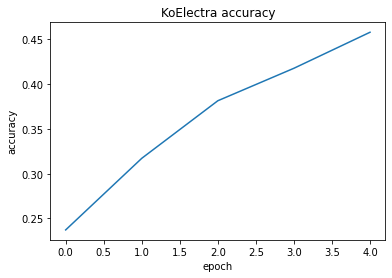

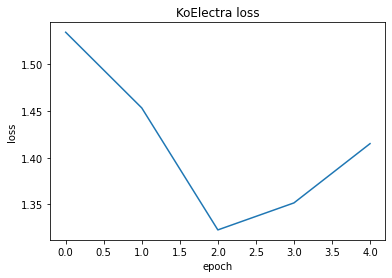

In [41]:
import matplotlib.pyplot as plt
plt.plot(accuracies)
# plt.plot(test_acc_list)
plt.title('KoElectra accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.legend(['train','val'])
plt.show()

plt.plot(losses_)
# plt.plot(test_loss_list_)
plt.title('KoElectra loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.legend(['train','val'])
plt.show()

In [ ]:
# 모델 저장하기
torch.save(model.state_dict(), "model.pt")